# Implementation of a search engine based on sBERT

In this notebook there is a basic implementation of sBERT for searching a database of sentences with queries.

The goal is to increase the amount of labeled data that we have in order to later fine tune a model to be used for sentence classification. First of all we have to find a pool of queries that represent the six labels of the six policy instruments. With these queries we can pull a set of sentences that can be automaticaly labeled with the same label of the query. In this way we can increase the diversity of labeled sentences in each label category. This approach will be complemented with a manual curation step to produce a high quality training data set.

The policy instruments that we want to find and that correspond to the different labels are:
* Direct payment (PES)
* Tax deduction
* Credit/guarantee
* Technical assistance
* Supplies
* Fines

This notebook is intended for the following purposes:
* Try different query strategies to find the optimal retrieval of sentences in each policy instrument category
* Try different transformers
* Be the starting point for further enhancements

## Import modules

This notebook is self contained, it does not depend on any other class of the sBERT folder.

You just have to create an environment where you install the external dependencies. Usually the dependencies that you have to install are:

**For the basic sentence similarity calculation**
*  pandas
*  boto3
*  pytorch
*  sentence_transformers

**If you want to use ngrams to generate queries**
*  nltk
*  plotly
*  wordcloud

**If you want to do evaluation and ploting with pyplot**
*  matplotlib

In [4]:
# If your environment is called nlp then you execute this cell otherwise you change the name of the environment
!conda activate wri_omdena

In [39]:
# General purpose libraries
import numpy as np
import pandas as pd
import boto3
import json
import time
import os

# Model libraries
from sentence_transformers import SentenceTransformer
from scipy.spatial import distance

# Libraries for model evaluation
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix

# Libraries to be used in the process of definig queries
import nltk # imports the natural language toolkit
from nltk.corpus import stopwords
import plotly
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
import re
import es_core_news_md
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

## Accesing documents in S3

All documents from El Salvador have been preprocessed and their contents saved in a JSON file. In the JSON file there are the sentences of interest.

Use the json file with the key and password to access the S3 bucket if necessary. 
If not, skip this section and use files in a local folder. 

In [11]:
# If you want to keep the credentials in a local folder out of GitHub, you can change the path to adapt it to your needs.
# Please, comment out other users lines and set your own
path = r"C:\Users\dcalle.MATONE\Documents\GitHub" # Jordi's local path in desktop
# path = "C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/credentials/" # Jordi's local path in laptop
# path = ""
#If you put the credentials file in the same "notebooks" folder then you can use the following path
# path = ""
filename = "Omdena_key_S3.json"
file = os.path.join(path, filename)
with open(file, 'r') as dict:
    key_dict = json.load(dict)

In [12]:
for key in key_dict:
    KEY = key
    SECRET = key_dict[key]

In [13]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-2',
    aws_access_key_id = KEY,
    aws_secret_access_key = SECRET
)

### Loading the sentence database from El Salvador

In [14]:
filename = 'JSON/ElSalvador.json'

obj = s3.Object('wri-latin-talent',filename)
serializedObject = obj.get()['Body'].read()
policy_list = json.loads(serializedObject)

### Building a list of potentially relevant sentences

Before going through the dictionary to retrieve sentences, we define a function to reduce de number of sentences in the final "sentences" dictionary. This is just for testing purposes. The reason being that running the sentence embedding function takes time. So for initial testing purposes we can reduce the number of sentences in the testing dataset.

The variable "slim_by" is the reduction factor. If it is set to 1, there will be no reduction and we will be working with the full dataset. It it is set to two, we will take one every two sentences and so one.

<span style="color:red"><strong>REMEMBER</strong></span> that you have to re-run the function "get_sentences_dict" with the "slim_by" variable set to 1 when you want to go for the final shoot.

In [15]:
def slim_dict(counter, slim_factor): # This is to shrink the sentences dict by a user set factor. It will pick only one sentence every "slim_factor"
    if counter % slim_factor == 0:
        return True
    else:
        return False
def sentence_length_filter(sentence_text, minLength, maxLength):
    if len(sentence_text) > minLength:#len(sentence_text) < maxLength and
        return True
    else:
        return False
    
def get_sentences_dict(docs_dict, is_not_incentive_dict, slim_factor, minLength, maxLength):
    count = 0
    result = {}
    for key, value in docs_dict.items():
        for item in value: 
            if item in is_not_incentive_dict:
                continue
            else:
                for sentence in docs_dict[key][item]['sentences']:
                    if sentence_length_filter(docs_dict[key][item]['sentences'][sentence]["text"], minLength, maxLength):
                        count += 1
                        if slim_dict(count, slim_by):
                            result[sentence] = docs_dict[key][item]['sentences'][sentence]
                        else:
                            continue
                    else:
                        continue
    return result

Here you will run the function to get your sentences list in a dictionary of this form:

{"\<sentence id\>" : "\<text of the sentence\>"}.

In [16]:
is_not_incentive = {"CONSIDERANDO:" : 0,
                    "POR TANTO" : 0,
                    "DISPOSICIONES GENERALES" : 0,
                    "OBJETO" : 0,
                    "COMPETENCIA, PROCEDIMIENTOS Y RECURSOS." : 0}

slim_by = 100 # REMEMBER to set this variable to the desired value.
min_length = 50 # Just to avoid short sentences which might be fragments or headings without a lot of value
max_length = 250 # Just to avoid long sentences which might be artifacts or long legal jargon separated by semicolons

sentences = get_sentences_dict(policy_list, is_not_incentive, slim_by, min_length, max_length)


In [57]:
print("In this data set there are {} policies and {} sentences".format(len(policy_list),len(sentences)))
# for sentence in sentences:
#     print(sentences[sentence]['text'])
sentences

In this data set there are 349 policies and 332 sentences


{'029d411_85': {'text': 'FALTAS MUY GRAVES: Aquellas que deterioran el medio ambiente y ponen en riesgo la vida de las personas',
  'labels': []},
 '029d411_219': {'text': '- Queda prohibido que animales domesticos (cerdos, perros, vacas y caballos u otros semovientes), transiten en las calles y las plazas publicas sin la conduccion de persona alguna',
  'labels': []},
 '04731ac_62': {'text': 'Asi mismo, durante el horario diurno, el personal de los vehiculos de reparto debera cargar y descargar las mercancias o cualquier otro objeto, sin producir impactos sobre el piso del vehiculo o del pavimento, debiendo evitar igualmente, la generacion de ruido contaminante por el desplazamiento de la carga durante el recorrido a su lugar de destino',
  'labels': []},
 '05149e3_149': {'text': 'Las modificaciones de los inventarios seran aprobadas por el Concejo Municipal con el Visto Bueno de la Institucion encargada de preservar el Patrimonio Cultural',
  'labels': []},
 '05f5ba4_76': {'text': 'P

## Defining Queries

### N-grams approach

In the following lines, we use the excel file with the selected phrases of each country, process them and get N-grams to define basic queries for the SBERT model.

In [84]:
file_loc = r"C:\Users\dcalle.MATONE\Downloads"
file = r"WRI Policy Tags Complete File phrases extraction all.xlsx"
path = os.path.join(file_loc,file)
data = pd.read_excel(path, sheet_name = None)
df = None

# if isinstance(data, dict):
for key, value in data.items():
    if not isinstance(df,pd.DataFrame):
        df = value
    else:
        df = df.append(value)
# else:
#     df = data
df

,Document,Original Text,"Relevant Sentences (for Environment, Incentives, Land Type)","Relevant Phrases (for Environment, Incentives, Land Type)",Incentive Instrument,Land Use Type,Category,Unique Policy #,Key words,Key Words,Comment
0,2019 ACUERDO por el que se emiten los Lineamie...,Generar empleo y garantizara la población camp...,Generar empleo y garantizara la población camp...,garantizara la población campesina el bienesta...,"Direct payment (PES), Credit, Technical assist...","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),"insumo, crédito, capacitación, asistencia técnica",NaN,NaN
1,2019 ACUERDO por el que se emiten los Lineamie...,\nEl Programa incentivará a los sujetos agrari...,\nEl Programa incentivará a los sujetos agrari...,incentivará a los sujetos agrarios a establece...,"Direct payment (PES), Credit, Technical assist...","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),incentivar,NaN,NaN
2,2019 ACUERDO por el que se emiten los Lineamie...,Los sujetos agrarios beneficiados por el progr...,Los sujetos agrarios beneficiados por el progr...,Los sujetos agrarios beneficiados por el progr...,"Supplies, Technical assistance","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),"apoyo económico, apoyos en especie, insumos, h...",NaN,NaN
3,2019 ACUERDO por el que se emiten los Lineamie...,"El sujeto de derecho, recibirá un apoyo económ...","El sujeto de derecho, recibirá un apoyo económ...","recibirá un apoyo económico de $5,000.00 (Cin...",Direct payment (PES),"Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),pesos,NaN,NaN
4,2019 ACUERDO por el que se emiten los Lineamie...,"El sujeto de derecho, recibirá en especie las ...","El sujeto de derecho, recibirá en especie las ...",recibirá en especie las plantas necesarias par...,Supplies,"Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),recibir,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
25,D8D49 REFORMA DE LA ORDENANZA PARA LA PROTECCI...,"Se prohíbe la tala de especies arbóreas, en es...","Se prohíbe la tala de especies arbóreas, en es...",Se prohíbe la tala de especies arbóreas;\ncond...,Fine,"Forest, Agriculture (Crop)",Incentive (Intention),NaN,NaN,NaN,Minor prohibitions relating to tree cutting; d...
26,D8D49 REFORMA DE LA ORDENANZA PARA LA PROTECCI...,Toda persona natural o jurídica que tale un ej...,Toda persona natural o jurídica que tale un ej...,tale un ejemplar arbóreo;\n resarcir el impac...,Fine,"Forest, Agriculture (Crop)",Incentive,NaN,NaN,NaN,NaN
27,DBE52 ORDENANZA AMBIENTAL DE LA ALCALDIA MUNIC...,Las personas que realicen actividades agrícola...,Las personas que realicen actividades agrícola...,"actividades agrícolas, pecuarias, forestales, ...",Fine,"Forest, Agriculture (Crop), Agriculture (Pasture)",Incentive,NaN,NaN,NaN,NaN
28,DBE52 ORDENANZA AMBIENTAL DE LA ALCALDIA MUNIC...,El interesado presentará solicitud de inspecci...,El interesado presentará solicitud de inspecci...,solicitud de inspección forestal;\nUnidad Amb...,Fine,Forest,Incentive,NaN,NaN,NaN,Includes small scale change of land use policies


Text(0.5, 1.0, 'Histogram of number of words per sentence')

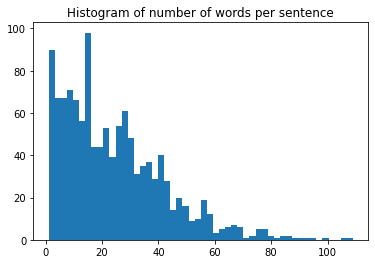

In [37]:
tagged_sentences = df["Relevant Sentences (for Environment, Incentives, Land Type) "].apply(lambda x: x.split(";") if isinstance(x,str) else x)
tagged_sentence = []

for elem in tagged_sentences:
    if isinstance(elem,float) or len(elem) == 0:
        continue
    elif isinstance(elem,list):
        for i in elem:
            if len(i.strip()) == 0:
                continue
            else:
                tagged_sentence.append(i.strip())
    else:
        if len(elem.strip()) == 0:
            continue
        else:
            tagged_sentence.append(elem.strip())

tagged_sentence
words_per_sentence = [len(x.split(" ")) for x in tagged_sentence]
plt.hist(words_per_sentence, bins = 50)
plt.title("Histogram of number of words per sentence")

In [42]:
def top_k_ngrams(word_tokens,n,k):
    
    ## Getting them as n-grams
    n_gram_list = list(ngrams(word_tokens, n))

    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    print(most_common_k)

noise_words = []
sp_stop_words = stopwords.words('spanish')
noise_words.extend(sp_stop_words)
print(len(noise_words))

if "no" in noise_words:
    noise_words.remove("no")

tokenized_words = nltk.word_tokenize(''.join(tagged_sentence))
word_freq = Counter(tokenized_words)
# word_freq.most_common(20)
# list(ngrams(tokenized_words, 3))

word_tokens_clean = [re.findall(r"[a-zA-Z]+",each) for each in tokenized_words if each.lower() not in noise_words and len(each.lower()) > 1]
word_tokens_clean = [each[0].lower() for each in word_tokens_clean if len(each)>0]

313


We define the size of the n-gram that we want to find. The larger it is, the less frequent it will be, unless we substantially increase the number of phrases.

In [76]:
n_grams = 1

bigrams = top_k_ngrams(word_tokens_clean, n_grams, 20)
bigrams

[('incentivos', 186), ('forestal', 150), ('manejo', 139), ('t', 130), ('forestales', 127), ('actividades', 111), ('pago', 95), ('a', 89), ('programa', 87), ('podr', 86), ('proyectos', 85), ('econ', 81), ('desarrollo', 79), ('derecho', 79), ('servicios', 78), ('no', 78), ('aprovechamiento', 77), ('ley', 76), ('producci', 74), ('recursos', 70)]


### Building queries with Parts-Of-Speech

The following functions take a specific word and find the next or previous words according to the POS tags.

An example is shown below with the text: <br>

text = "Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica" <br>

next_words(text, "empleo", 3) <br>
prev_words(text, "garantizara", 6) <br>

Will return: <br>

>['garantizara', 'población', 'campesina'] <br>
>['Generar', 'empleo']

In [47]:
nlp = es_core_news_md.load()

def ExtractInteresting(sentence, match = ["ADJ","ADV", "NOUN", "NUM", "VERB", "AUX"]):
    words = nltk.word_tokenize(sentence)
#     interesting = [k for k,v in nltk.pos_tag(words) if v in match]
    doc = nlp(sentence)
    interesting = [k.text for k in doc if k.pos_ in match]
    return(interesting)

def next_words(sentence, word, num_words, match = ["ADJ","ADV", "NOUN", "NUM", "VERB", "AUX"]):

    items = list()
    doc = nlp(sentence)
    text = [i.text for i in doc]

    if word not in text: return ""
    
    idx = text.index(word)
    for num in range(num_words):
        
        pos_words = [k.text for k in doc[idx:] if k.pos_ in match]
        if len(pos_words) > 1: 
            items.append(pos_words[1])
            idx = text.index(pos_words[1])
    
    return items
    
def prev_words(sentence, word, num_words, match = ["ADJ","ADV", "NOUN", "NUM", "VERB", "AUX"]):
    
    items = list()
    doc = nlp(sentence)
    text = [i.text for i in doc]

    if word not in text: return ""
    
    idx = text.index(word)
    for num in range(num_words):
        pos_words = [k.text for k in doc[:idx] if k.pos_ in match]
        if len(pos_words) >= 1: 
            items.insert(0, pos_words[-1]) #Add element in order and take the last element since it is the one before the word
            idx = text.index(pos_words[-1])
    
    return items

In [49]:
text = ''.join(tagged_sentence)

['estratégicas', 'país', 'enfoque', 'prácticas', 'buen', 'manejo']

In [77]:
next_words(text, "incentivos", 3)

['económicos', 'mensuales', 'cumplimiento']

In [78]:
prev_words(text, "incentivos", 6)

['mujeres',
 'objetivo',
 'incrementar',
 'productividad',
 'ecosistemas',
 'forestales']

### Keyword approach

In [52]:
# Regular expression to find incentive policy instruments
keywords = re.compile(r'(asistencia tecnica)|ayuda\s*s*\s*\b|\bbono\s*s*\b\s*|credito\s*s*\b\s*|deduccion\s*(es)*\b\s*|devolucion\s*(es)*\b\s*|incentivo\s*s*\b\s*|insumo\s*s*\b\s*|multa\s*s*\b\s*')

# Function to change accented words by non-accented counterparts. It depends on the dictionary "accent_marks_bugs" 
accents_out = re.compile(r'[áéíóúÁÉÍÓÚ]')
accents_dict = {"á":"a","é":"e","í":"i","ó":"o","ú":"u","Á":"A","É":"E","Í":"I","Ó":"O","Ú":"U"}
def remove_accents(string):
    for accent in accents_out.findall(string):
        string = string.replace(accent, accents_dict[accent])
    return string
# Dictionary to merge variants of a word
families = {
    "asistencia tecnica" : "asistencia técnica",
    "ayuda" : "ayuda",
    "ayudas" : "ayuda",
    "bono" : "bono",
    "bonos" : "bono",
    "credito":  "crédito",
    "creditos":  "crédito",
    "deduccion" : "deducción",
    "deducciones" : "deducción",
    "devolucion" : "devolución",
    "devoluciones" : "devolución",
    "incentivo" : "incentivo",
    "incentivos" : "incentivo",
    "insumo" : "insumo",
    "insumos" : "insumo",
    "multa" : "multa",
    "multas" : "multa"
}

In [53]:
keyword_in_sentences = []
            
for sentence in sentences:
    line = remove_accents(sentences[sentence]['text'])
    hit = keywords.search(line)
    if hit:
        keyword = hit.group(0).rstrip().lstrip()
        keyword_in_sentences.append([families[keyword], sentences[sentence]['text']])             

In [54]:
print(len(keyword_in_sentences))
keyword_in_sentences = sorted(keyword_in_sentences, key = lambda x : x[0])
# print(keyword_in_sentences[0:20])
filtered = [row for row in keyword_in_sentences if row[0] == "asistencia técnica"]
filtered

8


[]

In [55]:
i = 0
for key, value in families.items():
    if i % 2 == 0:
        print(value, "--", len([row for row in keyword_in_sentences if row[0] == value]))
    i += 1
    

asistencia técnica -- 0
ayuda -- 0
bono -- 0
crédito -- 0
deducción -- 0
devolución -- 0
incentivo -- 0
insumo -- 0
multa -- 8


In [56]:
incentives = {}

for incentive in families:
    incentives[families[incentive]] = 0
    
incentives

{'asistencia técnica': 0,
 'ayuda': 0,
 'bono': 0,
 'crédito': 0,
 'deducción': 0,
 'devolución': 0,
 'incentivo': 0,
 'insumo': 0,
 'multa': 0}

## Using the model

### Initializing the model

First, we import the sBERT model. Several transformers are available and documentation is here: https://github.com/UKPLab/sentence-transformers <br>

Then we build a simple function that takes four inputs:
1. The model as we have set it in the previous line of code
2. A dictionary that contains the sentences {"\<sentence_ID\>" : {"text" : "The actual sentence", labels : []}
3. A query in the form of a string
4. A similarity treshold. It is a float that we can use to limit the results list to the most relevant.

The output of the function is a list with three columns with the following content:
1. Column 1 contains the id of the sentence
2. Column 2 contains the similarity score
3. Column 3 contains the text of the sentence that has been compared with the query

#### Modeling functions

There are currently two multi language models available for sentence similarity

* xlm-r-bert-base-nli-stsb-mean-tokens: Produces similar embeddings as the bert-base-nli-stsb-mean-token model. Trained on parallel data for 50+ languages.
<span style="color:red"><strong>Attention!</strong></span> Model "xlm-r-100langs-bert-base-nli-mean-tokens" which was the name used in the original Omdena-challenge script has changed to this "xlm-r-bert-base-nli-stsb-mean-tokens"

* distiluse-base-multilingual-cased-v2: Multilingual knowledge distilled version of multilingual Universal Sentence Encoder. While the original mUSE model only supports 16 languages, this multilingual knowledge distilled version supports 50+ languages

In [58]:
# This function is to create the embeddings for each transformer the embeddings in a json with the following structure:
# INPUT PARAMETERS
# transformers: a list with transformer names
# sentences_dict: a dictionary with the sentences of the database with the form {"<sentence id>" : "<sentence text>"}}
# file: the filepath and filename of the output json
# OUTPUT
# the embeddings of the sentences in a json with the following structure:
# {"<transformer name>" : {"<sentence id>" : <sentence embedding>}}

def create_sentence_embeddings(transformers, sentences_dict, file):
    embeddings = {}
    for transformer_name in transformers:
        model = SentenceTransformer(transformer_name)
        embeddings[transformer_name] = {}
        for sentence in sentences_dict:
            embeddings[transformer_name][sentence] = [model.encode(sentences_dict[sentence]['text'].lower())]
    with open(file, 'w') as fp:
        json.dump(embeddings, fp, cls=NumpyArrayEncoder)
     
   
def highlight(transformer_name, model, sentence_emb, sentences_dict, query, similarity_treshold):
    query_embedding = model.encode(query.lower())
    highlights = []
    for sentence in sentence_emb[transformer_name]:
        sentence_embedding = np.asarray(sentence_emb[transformer_name][sentence])[0]
        score = 1 - distance.cosine(sentence_embedding, query_embedding)
        if score > similarity_treshold:
            highlights.append([sentence, score, sentences_dict[sentence]['text']])
    highlights = sorted(highlights, key = lambda x : x[1], reverse = True)
    return highlights


#### Create embeddings for sentences in the database

This piece of code it's to be executed only once every time the database is chaged or we want to get the embeddings of a new database. For example, we are going to use it once for El Salvador policies and we don't need to use it again until we add new policies to this database. Instead, whenever we want to run experiments on this database, we will load the json files with the embeddings which are in the "input" folder.

So, the next cell will be kept commented for safety reasons. Un comment it and execute it whenvere you need it.

In [59]:
Ti = time.perf_counter()

transformer_names =['xlm-r-bert-base-nli-stsb-mean-tokens']#, 'distiluse-base-multilingual-cased-v2']

path = "../input/"
filename = "Embeddings_ElSalvador_201216.json"
file = path + filename

create_sentence_embeddings(transformer_names, sentences, file)

Tf = time.perf_counter()

print(f"The building of a sentence embedding database for El Salvador in the two current models has taken {Tf - Ti:0.4f} seconds")

100%|█████████████████████████████████████████████████████████████████████████████| 1.01G/1.01G [15:06<00:00, 1.12MB/s]


The building of a sentence embedding database for El Salvador in the two current models has taken 942.1459 seconds


#### Loading the embeddings for database sentences

In [60]:
path = "../input/"
filename = "Embeddings_ElSalvador_201216.json"
file = path + filename

with open(file, "r") as f:
    sentence_embeddings = json.load(f)

### Running the search

#### Basic search with single test query

In [61]:
# First load transformers into the model by choosing one model from index
transformer_names =['xlm-r-bert-base-nli-stsb-mean-tokens', 'distiluse-base-multilingual-cased-v2']
model_index = 0
model = SentenceTransformer(transformer_names[model_index])

In [81]:
# Now, perform single query searches by manually writing a query in the corresponding field
Ti = time.perf_counter()

highlighter_query = "manejo forestal recursos incentivo economico"
similarity_limit = 0.00

label_1 = highlight(transformer_names[model_index], model, sentence_embeddings, sentences, highlighter_query, similarity_limit)

Tf = time.perf_counter()

print(f"similarity search for El Salvador sentences done in {Tf - Ti:0.4f} seconds")

similarity search for El Salvador sentences done in 0.0738 seconds


In [80]:
print(len(label_1))
label_1[0:10]

316


[['1a77612_116',
  0.7447088079125025,
  '- Es competencia de la Municipalidad el fomentar el incremento de los recursos forestales dentro del radio urbano y rural'],
 ['e2bb383_300',
  0.7229543220777149,
  '- Para la gestion y aprovechamiento sostenible de los bosques, se debera tomar en cuenta lo siguiente:'],
 ['1ffdee7_66',
  0.692692816753735,
  'REFORESTACION: Es el establecimiento de un bosque en forma natural o artificial, sobre terrenos en los que la vegetacion arborea es'],
 ['7289291_97',
  0.6539517047868416,
  'b) Campañas de reforestacion en la zona rural y arborizacion del casco urbano del Municipio, fomentando principalmente la siembra de arboles frutales y flora autoctona,'],
 ['88ad2ff_269',
  0.6448090286731275,
  'Estas zonas forman las llamadas campiñas agricolas, que constituyen paisajes rurales de gran belleza y poder evocador, cuyo valor ambiental resulta relevante para la poblacion'],
 ['8e81fe2_205',
  0.6381484056133255,
  '- La compensacion sera obligatoria

##### Inspecting the results

In [82]:
print(highlighter_query)
label_1[0:40]

manejo forestal recursos incentivo economico


[['1a77612_116',
  0.7514486966989751,
  '- Es competencia de la Municipalidad el fomentar el incremento de los recursos forestales dentro del radio urbano y rural'],
 ['e2bb383_300',
  0.7246733698104354,
  '- Para la gestion y aprovechamiento sostenible de los bosques, se debera tomar en cuenta lo siguiente:'],
 ['1ffdee7_66',
  0.6871265676338183,
  'REFORESTACION: Es el establecimiento de un bosque en forma natural o artificial, sobre terrenos en los que la vegetacion arborea es'],
 ['88ad2ff_269',
  0.6572027205819188,
  'Estas zonas forman las llamadas campiñas agricolas, que constituyen paisajes rurales de gran belleza y poder evocador, cuyo valor ambiental resulta relevante para la poblacion'],
 ['7289291_97',
  0.656933618172703,
  'b) Campañas de reforestacion en la zona rural y arborizacion del casco urbano del Municipio, fomentando principalmente la siembra de arboles frutales y flora autoctona,'],
 ['8e81fe2_205',
  0.6368592265954419,
  '- La compensacion sera obligatoria

##### Further filtering of the results by using the similarity score

In [70]:
similarity_treshold = 0.5
filtered = [row for row in label_1 if row[1] > similarity_treshold]
filtered

[['dab533a_175',
  0.7138322707937985,
  'El calculo de la compensacion se realizara de la siguiente forma:'],
 ['838e245_44',
  0.6304494605673723,
  'PPCO - Plan Parcial de uso Comercio-servicios-oficinas'],
 ['838e245_291',
  0.5917932756932498,
  '- El plazo para la liquidacion o pago del monto o aporte de cualquiera de las compensaciones calculadas, podra ser mutuamente acordado'],
 ['735ad07_56',
  0.5617702483177716,
  '00 Dolares de los Estados Unidos de America segun la gravedad del caso'],
 ['498aa7d_54',
  0.5523079526558828,
  'Lote ALTURA AREA AREA RETIRO RETIRO RODAJE INFRAEST'],
 ['b189d15_499',
  0.5137718015272386,
  'Calificacion de lugar, por cada m2 del area total del terreno $ 0'],
 ['a0dcb6f_144',
  0.5094704624166887,
  'Usos Complementarios: Son los usos que complementan los usos predominantes'],
 ['50f28b4_34',
  0.5030239137921334,
  'En consecuencia se establece las medidas siguientes:'],
 ['a0dcb6f_443',
  0.5020787053773023,
  'de soedsa usAny]suos UQI9ez1¡

##### Exporting results

In [ ]:
# Create a dataframe
export_query = pd.DataFrame(label_1)
#export file 
export_query = pd.DataFrame(label_1)

#### Multiparameter search design

In [ ]:
dicti = {}
i= 0
for key in incentives:
    if i < 2:
        dicti[key] = 0
    i += 1
incentives = dicti
    

In [ ]:
transformer_names =['xlm-r-bert-base-nli-stsb-mean-tokens']#, 'distiluse-base-multilingual-cased-v2']
similarity_limit = 0.2
number_of_search_results = 50
results = {}

for transformer in transformer_names:
    model = SentenceTransformer(transformer)
    results[transformer] = {}
    for incentive in incentives:
        queries = [incentive, [row for row in keyword_in_sentences if row[0] == incentive][0][1]]
        Ti = time.perf_counter()
        for query in queries:
            similarities = highlight(transformer, model, sentence_embeddings, sentences, query, similarity_limit)
            results[transformer][query] = similarities[0:number_of_search_results]
            Tf = time.perf_counter()
            print(f"similarity search for model {transformer} and query {query} it's been done in {Tf - Ti:0.4f} seconds")

path = "../output/"
filename = "test.json"
file = path + filename
with open(file, 'w') as fp:
    json.dump(results, fp, indent=4)